In [1]:
import gym
import torch
import torch.nn as nn
import numpy as np
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpy'

In [5]:
class Actor(nn.Module):
  def __init__(self,input_size:int=4,hidden_size:int=16,output_size:int=2):
    super().__init__()
    self.fc1 = nn.Linear(input_size,hidden_size)
    self.fc2 = nn.Linear(hidden_size,output_size)

  def forward(self,s):
    outs = self.fc1(s)
    outs = F.relu(outs)
    logits = self.fc2(outs)
    return logits


class Critic(nn.Module):
  def __init__(self,input_size:int=4,hidden_size:int=16,output_size:int=1):
    super().__init__()
    self.fc1 = nn.Linear(input_size,hidden_size)
    self.fc2 = nn.Linear(hidden_size,output_size)

  def forward(self,s):
    outs = self.fc1(s)
    outs = F.relu(outs)
    value = self.fc2(outs)
    return value



In [12]:
class Agent:
  def __init__(self,
               actor,
               critic,
               actor_opt,
               critic_opt,
               env_name:str="CartPole-v1",
               gamma:float=0.99):
    self.actor = actor
    self.critic = critic
    self.actor_opt = actor_opt
    self.critic_opt = critic_opt
    self.env = gym.make(env_name)
    self.gamma = gamma
    self.reward_records = []

  def sample(self,s):
    with torch.no_grad():
      s_batch = np.expand_dims(s,axis=0)
      s_batch = torch.tensor(s_batch,dtype=torch.float).to(device)
      logits = self.actor(s_batch)
      logits = logits.squeeze(dim=0)
      probs = F.softmax(logits,dim=-1)
      a = torch.multinomial(probs,num_samples=1)
      return a.tolist()[0]

  def train(self):
    for i in range(1500):
      done = False
      states = []
      actions = []
      rewards = []
      s= self.env.reset()
      while not done:
        states.append(s.tolist())
        a = self.sample(s)
        s,r,term,trunc = self.env.step(a)
        done = term or trunc
        actions.append(a)
        rewards.append(r)

      # Get cumulative rewards

      cum_rewards = np.zeros_like(rewards)
      for j in reversed(range(len(cum_rewards))):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*self.gamma if j+1 < len(rewards) else 0)

      # Optimize Critic loss
      self.critic_opt.zero_grad()
      states = torch.tensor(states,dtype=torch.float).to(device)
      cum_rewards = torch.tensor(cum_rewards,dtype=torch.float).to(device)
      values = self.critic(states)
      values = values.squeeze(dim=1)
      critic_loss = F.mse_loss(values,cum_rewards,reduction='none')
      critic_loss.sum().backward()
      self.critic_opt.step()

      # Optimize Actor loss
      with torch.no_grad():
        values = self.critic(states)

      self.actor_opt.zero_grad()
      actions = torch.tensor(actions,dtype=torch.int64).to(device)
      advantages = cum_rewards - values
      logits = self.actor(states)
      log_probs = -F.cross_entropy(logits,actions,reduction='none')
      pi_loss = -log_probs * advantages
      pi_loss.sum().backward()
      self.actor_opt.step()

      # Output total rewards in episode (max 500)
      print("Run episode{} with rewards {}".format(i, sum(rewards)))
      self.reward_records.append(sum(rewards))

      # stop if reward mean > 475.0
      if np.average(self.reward_records[-50:]) > 475.0:
          break
    print('\nDone')
    self.env.close()


  def plot(self):
    import matplotlib.pyplot as plt
    # Generate recent 50 interval average
    average_reward = []
    for idx in range(len(self.reward_records)):
      avg_list = np.empty(shape=(1,), dtype=int)
      if idx < 50:
          avg_list = self.reward_records[:idx+1]
      else:
          avg_list = self.reward_records[idx-49:idx+1]
      average_reward.append(np.average(avg_list))
    plt.plot(self.reward_records)
    plt.plot(average_reward)















Run episode0 with rewards 12.0
Run episode1 with rewards 13.0
Run episode2 with rewards 14.0
Run episode3 with rewards 44.0
Run episode4 with rewards 16.0
Run episode5 with rewards 16.0
Run episode6 with rewards 20.0
Run episode7 with rewards 21.0
Run episode8 with rewards 19.0
Run episode9 with rewards 24.0
Run episode10 with rewards 10.0
Run episode11 with rewards 30.0
Run episode12 with rewards 51.0
Run episode13 with rewards 26.0
Run episode14 with rewards 34.0
Run episode15 with rewards 19.0
Run episode16 with rewards 47.0
Run episode17 with rewards 28.0
Run episode18 with rewards 19.0
Run episode19 with rewards 29.0
Run episode20 with rewards 36.0
Run episode21 with rewards 16.0
Run episode22 with rewards 18.0
Run episode23 with rewards 12.0
Run episode24 with rewards 16.0
Run episode25 with rewards 8.0
Run episode26 with rewards 9.0
Run episode27 with rewards 14.0
Run episode28 with rewards 19.0
Run episode29 with rewards 13.0
Run episode30 with rewards 16.0
Run episode31 with r

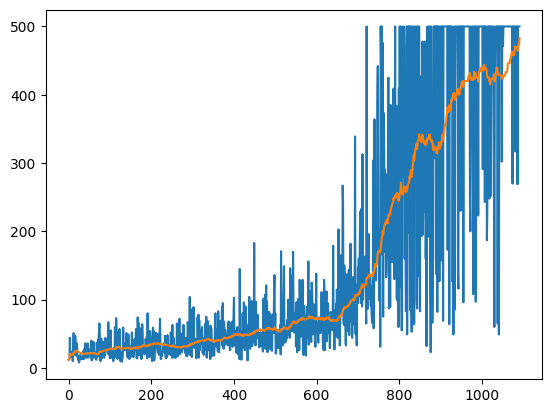

In [13]:
actor = Actor().to(device)
critic = Critic().to(device)
actor_opt = torch.optim.AdamW(actor.parameters(), lr=0.001)
critic_opt = torch.optim.AdamW(critic.parameters(), lr=0.001)
agent = Agent(actor,critic,actor_opt,critic_opt)
agent.train()
agent.plot()